In [ ]:
# import tensorflow as tf
# from tensorflow.keras.models import load_model
# # Load your model
# model = load_model("/content/model-cropped-224.h5")

# # Convert to TFLite format
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# tflite_model = converter.convert()

# # Save the model
# with open("model-cropped-224.tflite", "wb") as f:
#     f.write(tflite_model)

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model
import cv2
from sklearn.metrics import accuracy_score
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import sys
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
import numpy as np
import shutil
import zipfile
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from collections import Counter
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import Sequence
import random
import tensorflow.keras.backend as K


In [ ]:
test_zip_path = "/content/drive/MyDrive/Master/Dizertatie/cropped-test-300.zip"
metadata_path = "/content/drive/MyDrive/Master/Dizertatie/BCN20000/bcn20000_metadata_2024-12-04.csv"
# metadata_path = "/content/drive/MyDrive/Master/Dizertatie/HAM10000_metadata.csv"
local_test_zip_path = "/content/test.zip"
local_metadata_path = "/content/metadata.csv"

model_224_path = "/content/drive/MyDrive/Master/Dizertatie/model-cropped-224-v2.h5"
model_240_path = "/content/drive/MyDrive/Master/Dizertatie/model-cropped-240.h5"
model_260_path = "/content/drive/MyDrive/Master/Dizertatie/model-cropped-260.h5"
model_300_path = "/content/drive/MyDrive/Master/Dizertatie/model-cropped-300.h5"
metadata_224_path = "/content/drive/MyDrive/Master/Dizertatie/fusion_model_224.keras"
metadata_240_path = "/content/drive/MyDrive/Master/Dizertatie/fusion_model_240.keras"
metadata_260_path = "/content/drive/MyDrive/Master/Dizertatie/fusion_model_260.keras"
metadata_300_path = "/content/drive/MyDrive/Master/Dizertatie/fusion_model_300.keras"

shutil.copy(test_zip_path, local_test_zip_path)
shutil.copy(metadata_path, local_metadata_path)
print(f"The file was copied locally: {local_test_zip_path}")
print(f"The file was copied locally: {local_metadata_path}")


The file was copied locally: /content/test.zip
The file was copied locally: /content/metadata.csv


In [ ]:
extract_folder_test = "/content/test/"
os.makedirs(extract_folder_test, exist_ok=True)
with zipfile.ZipFile(local_test_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder_test)
print(f"Files were added to: {extract_folder_test}")


Files were added to: /content/test/


In [ ]:
test_image_folder = extract_folder_test + 'cropped-test-300/'
metadata = pd.read_csv(metadata_path)

In [ ]:
def create_metadata_dict(metadata, image_folder):
    """
    Creates a dictionary mapping image filenames to metadata feature vectors.

    - One-hot encodes `anatom_site_general` (6 categories)
    - One-hot encodes `sex` (2 categories: male, female)
    - Uses numerical encoding for `age_approx` with missing values set to -5.

    Parameters:
    - metadata (pd.DataFrame): DataFrame containing 'isic_id', 'age_approx', 'anatom_site_general', 'sex'.
    - image_folder (str): Path to the folder containing images.

    Returns:
    - dict: Mapping of {filename: feature_vector}.
    """
    # Ensure missing ages are set to -5
    metadata['age_approx'].fillna(-5, inplace=True)

    # One-hot encoding for `anatom_site_general`
    anatomical_sites = ["anterior torso", "lower extremity", "upper extremity",
                        "head/neck", "palms/soles", "oral/genital"]
    anatomical_one_hot = pd.get_dummies(metadata['anatom_site_general'], columns=anatomical_sites)

    # One-hot encoding for `sex`
    sex_categories = ["male", "female"]
    sex_one_hot = pd.get_dummies(metadata['sex'], columns=sex_categories)

    # Concatenate one-hot encodings with `age_approx`
    metadata_encoded = pd.concat([metadata[['isic_id', 'age_approx']], anatomical_one_hot, sex_one_hot], axis=1)

    # Convert to dictionary {filename: feature_vector}
    metadata_dict = {}
    for file in os.listdir(image_folder):
        if file.endswith(".jpg"):
            isic_id = file.split('.')[0]  # Extract ISIC ID from filename
            meta_row = metadata_encoded[metadata_encoded['isic_id'] == isic_id]

            if not meta_row.empty:
                # Convert row to a NumPy array
                feature_vector = meta_row.drop(columns=['isic_id']).values[0].astype(np.float32)
                metadata_dict[file] = feature_vector

    return metadata_dict

def create_label_dict(metadata, diagnosis_mapping, image_folder):
    """
    Creates a dictionary mapping image filenames to labels

    Parameters:
    - metadata (pd.DataFrame):DataFrame containing 'isic_id' and 'diagnosis'.
    - diagnosis_mapping (dict): dictionary with the diagnosis
    - image_folder (str): Path to the folder containing images.

    Returns:
    - dict: Mapping of {filename: class}
    """
    label_dict = {}

    for file in os.listdir(image_folder):
        if file.endswith(".jpg"):
            isic_id = file[:12]
            diagnosis = metadata.loc[metadata['isic_id'] == isic_id, 'diagnosis']

            if not diagnosis.empty:
                label_dict[file] = diagnosis_mapping[diagnosis.values[0]]

    return label_dict


def create_diagnosis_mapping(metadata):
    """
    Creates a mapping from diagnosis to numerical labels.

    Parameters:
    - metadata (pd.DataFrame): Metadata DataFrame containing 'diagnosis'.

    Returns:
    - dict: Mapping of diagnosis to numerical labels.
    """
    return {diag: idx for idx, diag in enumerate(metadata['diagnosis'].unique())}

In [ ]:
# For BCN

diagnosis_mapping = create_diagnosis_mapping(metadata)
test_labels = create_label_dict(metadata, diagnosis_mapping, test_image_folder)
metadata_labels = create_metadata_dict(metadata, test_image_folder)

<ipython-input-7-9236974f36e5>:42: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  metadata['age_approx'].fillna(-5, inplace=True)
<ipython-input-7-9236974f36e5>:42: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using

In [ ]:
diagnosis_mapping = create_diagnosis_mapping(metadata)
diagnosis_mapping

{'nevus': 0,
 'melanoma': 1,
 'other': 2,
 'squamous cell carcinoma': 3,
 'solar lentigo': 4,
 'basal cell carcinoma': 5,
 'melanoma metastasis': 6,
 'seborrheic keratosis': 7,
 'actinic keratosis': 8,
 'dermatofibroma': 9,
 'scar': 10,
 'vascular lesion': 11}

{'nevus': 0,
 'melanoma': 1,
 'other': 2,
 'squamous cell carcinoma': 3,
 'solar lentigo': 4,
 'basal cell carcinoma': 5,
 'melanoma metastasis': 6,
 'seborrheic keratosis': 7,
 'actinic keratosis': 8,
 'dermatofibroma': 9,
 'scar': 10,
 'vascular lesion': 11}

In [ ]:
metadata

,isic_id,attribution,copyright_license,age_approx,anatom_site_general,benign_malignant,concomitant_biopsy,diagnosis,diagnosis_1,diagnosis_2,diagnosis_3,diagnosis_confirm_type,image_type,lesion_id,melanocytic,sex
0,ISIC_0053453,Hospital Clínic de Barcelona,CC-BY-NC,60.0,anterior torso,benign,True,nevus,Benign,Benign melanocytic proliferations,Nevus,histopathology,dermoscopic,IL_0433332,True,male
1,ISIC_0053454,Hospital Clínic de Barcelona,CC-BY-NC,55.0,anterior torso,malignant,True,melanoma,Malignant,Malignant melanocytic proliferations (Melanoma),"Melanoma, NOS",histopathology,dermoscopic,IL_8314504,True,male
2,ISIC_0053455,Hospital Clínic de Barcelona,CC-BY-NC,50.0,lower extremity,NaN,True,other,NaN,NaN,NaN,histopathology,dermoscopic,IL_8065011,NaN,male
3,ISIC_0053456,Hospital Clínic de Barcelona,CC-BY-NC,50.0,anterior torso,malignant,True,melanoma,Malignant,Malignant melanocytic proliferations (Melanoma),"Melanoma, NOS",histopathology,dermoscopic,IL_5496448,True,female
4,ISIC_0053457,Hospital Clínic de Barcelona,CC-BY-NC,85.0,head/neck,NaN,True,squamous cell carcinoma,Malignant,Malignant epidermal proliferations,"Squamous cell carcinoma, NOS",histopathology,dermoscopic,IL_7128083,False,male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18941,ISIC_0073250,Hospital Clínic de Barcelona,CC-BY-NC,30.0,anterior torso,benign,False,nevus,Benign,Benign melanocytic proliferations,Nevus,NaN,dermoscopic,IL_9019520,True,female
18942,ISIC_0073251,Hospital Clínic de Barcelona,CC-BY-NC,55.0,palms/soles,benign,True,nevus,Benign,Benign melanocytic proliferations,Nevus,histopathology,dermoscopic,IL_2134464,True,female
18943,ISIC_0073252,Hospital Clínic de Barcelona,CC-BY-NC,85.0,head/neck,NaN,True,melanoma metastasis,Malignant,Malignant melanocytic proliferations (Melanoma),Melanoma metastasis,histopathology,dermoscopic,IL_5793605,True,female
18944,ISIC_0073253,Hospital Clínic de Barcelona,CC-BY-NC,70.0,anterior torso,NaN,True,other,NaN,NaN,NaN,histopathology,dermoscopic,IL_0260735,NaN,male


,isic_id,attribution,copyright_license,age_approx,anatom_site_general,benign_malignant,concomitant_biopsy,diagnosis,diagnosis_1,diagnosis_2,diagnosis_3,diagnosis_confirm_type,image_type,lesion_id,melanocytic,sex
0,ISIC_0053453,Hospital Clínic de Barcelona,CC-BY-NC,60.0,anterior torso,benign,True,nevus,Benign,Benign melanocytic proliferations,Nevus,histopathology,dermoscopic,IL_0433332,True,male
1,ISIC_0053454,Hospital Clínic de Barcelona,CC-BY-NC,55.0,anterior torso,malignant,True,melanoma,Malignant,Malignant melanocytic proliferations (Melanoma),"Melanoma, NOS",histopathology,dermoscopic,IL_8314504,True,male
2,ISIC_0053455,Hospital Clínic de Barcelona,CC-BY-NC,50.0,lower extremity,NaN,True,other,NaN,NaN,NaN,histopathology,dermoscopic,IL_8065011,NaN,male
3,ISIC_0053456,Hospital Clínic de Barcelona,CC-BY-NC,50.0,anterior torso,malignant,True,melanoma,Malignant,Malignant melanocytic proliferations (Melanoma),"Melanoma, NOS",histopathology,dermoscopic,IL_5496448,True,female
4,ISIC_0053457,Hospital Clínic de Barcelona,CC-BY-NC,85.0,head/neck,NaN,True,squamous cell carcinoma,Malignant,Malignant epidermal proliferations,"Squamous cell carcinoma, NOS",histopathology,dermoscopic,IL_7128083,False,male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18941,ISIC_0073250,Hospital Clínic de Barcelona,CC-BY-NC,30.0,anterior torso,benign,False,nevus,Benign,Benign melanocytic proliferations,Nevus,NaN,dermoscopic,IL_9019520,True,female
18942,ISIC_0073251,Hospital Clínic de Barcelona,CC-BY-NC,55.0,palms/soles,benign,True,nevus,Benign,Benign melanocytic proliferations,Nevus,histopathology,dermoscopic,IL_2134464,True,female
18943,ISIC_0073252,Hospital Clínic de Barcelona,CC-BY-NC,85.0,head/neck,NaN,True,melanoma metastasis,Malignant,Malignant melanocytic proliferations (Melanoma),Melanoma metastasis,histopathology,dermoscopic,IL_5793605,True,female
18944,ISIC_0073253,Hospital Clínic de Barcelona,CC-BY-NC,70.0,anterior torso,NaN,True,other,NaN,NaN,NaN,histopathology,dermoscopic,IL_0260735,NaN,male


In [ ]:
len(test_labels)

4737

4737

In [ ]:
def create_image_metadata_generator(image_folder, metadata_dict, label_dict, num_classes, batch_size=32, target_size=(224, 224)):
    """
    Creates a generator that yields image data, metadata features, and labels.

    Parameters:
    - image_folder (str): Path to the folder containing images.
    - metadata_dict (dict): Precomputed dictionary with metadata features.
    - label_dict (dict): Dictionary mapping image filenames to class labels.
    - num_classes (int): Number of output classes.
    - batch_size (int): Batch size for training.
    - target_size (tuple): Target image size (default: 224x224).

    Yields:
    - images (np.array): Image batch.
    - metadata_features (np.array): Corresponding metadata batch.
    - labels (np.array): One-hot encoded labels.
    """
    image_files = [f for f in os.listdir(image_folder) if f in label_dict and f in metadata_dict]

    while True:
        random.shuffle(image_files) 

        for i in range(0, len(image_files), batch_size):
            batch_files = image_files[i:i + batch_size]
            images, metadata_features, labels = [], [], []

            for file in batch_files:
                img_path = os.path.join(image_folder, file)
                img = load_img(img_path, target_size=target_size)
                img_array = img_to_array(img).astype('float32') / 255.0  

          
                meta_features = metadata_dict[file]

                images.append(img_array)
                metadata_features.append(meta_features)
                labels.append(label_dict[file])

            # Convert lists to NumPy arrays
            images = np.array(images)
            metadata_features = np.array(metadata_features, dtype=np.float32)
            labels = to_categorical(labels, num_classes=num_classes)

            yield {"input_layer": images, "metadata_input": metadata_features}, labels

def create_image_generator(image_folder, label_dict, num_classes, batch_size=32, target_size=(224, 224)):
    """
    Creates a generator for images, labels, and sample weights.
    """
    image_files = [f for f in os.listdir(image_folder) if f in label_dict]

    while True:
        random.shuffle(image_files) 

        for i in range(0, len(image_files), batch_size):
            batch_files = image_files[i:i + batch_size]
            images, labels = [], []

            for file in batch_files:
                img_path = os.path.join(image_folder, file)
                img = load_img(img_path, target_size=target_size)
                img_array = img_to_array(img).astype('float32') / 255.0 

                label = label_dict[file]

                images.append(img_array)
                labels.append(label)

            images = np.array(images)
            labels = to_categorical(labels, num_classes=num_classes)

            yield images, labels

def sensitivity(y_true, y_pred):
    """Computes sensitivity (recall) for multi-class classification"""
    y_true = K.cast(y_true, dtype='float32')  
    y_pred = K.cast(y_pred, dtype='float32')

    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))

    return true_positives / (possible_positives + K.epsilon())

In [ ]:
custom_objects = {"sensitivity": sensitivity}  # Define if needed
model_224 = load_model(model_224_path, custom_objects=custom_objects)
model_240 = load_model(model_240_path, custom_objects=custom_objects)
model_260 = load_model(model_260_path, custom_objects=custom_objects)
model_300 = load_model(model_300_path, custom_objects=custom_objects)

metadata_model_224 = load_model(metadata_224_path, custom_objects=custom_objects)
metadata_model_240 = load_model(metadata_240_path, custom_objects=custom_objects)
metadata_model_260 = load_model(metadata_260_path, custom_objects=custom_objects)
metadata_model_300 = load_model(metadata_300_path, custom_objects=custom_objects)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 38 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 38 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
models = {"model_224": model_224,
          "model_240": model_240,
          "model_260": model_260,
          "model_300": model_300,
          "metadata_model_224": metadata_model_224,
          "metadata_model_240": metadata_model_240,
          "metadata_model_260": metadata_model_260,
          "metadata_model_300": metadata_model_300
          }

In [ ]:

BATCH_SIZE = 32
NUM_CLASSES = 12
STEPS = len(test_labels) // BATCH_SIZE  

IMG_SIZES = {"model_224": (224, 224),
             "model_240": (240, 240),
             "model_260": (260, 260),
             "model_300": (300, 300),
             "metadata_model_224": (224, 224),
             "metadata_model_240": (240, 240),
             "metadata_model_260": (260, 260),
             "metadata_model_300": (300, 300)}

# Evaluate each model with its corresponding image size
for model_name, model in models.items():
    target_size = IMG_SIZES[model_name]  # Select size based on model

    test_generator = create_image_generator(
        test_image_folder, test_labels,
        num_classes=NUM_CLASSES, batch_size=BATCH_SIZE, target_size=target_size
    )
    test_generator_metadata = create_image_metadata_generator(
        test_image_folder, metadata_labels, test_labels,
        num_classes=NUM_CLASSES, batch_size=BATCH_SIZE, target_size=target_size
    )

    steps = len(test_labels) // BATCH_SIZE  # Calculate steps for evaluation

    if "metadata" in model_name:
      loss, accuracy, sensitivity = model.evaluate(test_generator_metadata, steps=steps)
      print(f"{model_name} - Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}, Test Sensitivity: {sensitivity:.4f}")
    elif model_name != 'model_224':
      loss, accuracy, sensitivity = model.evaluate(test_generator, steps=steps)
      print(f"{model_name} - Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}, Test Sensitivity: {sensitivity:.4f}")
    else:
      loss, accuracy = model.evaluate(test_generator, steps=steps)
      print(f"{model_name} - Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")



148/148 ━━━━━━━━━━━━━━━━━━━━ 19s 52ms/step - accuracy: 0.8124 - loss: 1.2689
model_224 - Test Loss: 1.2566, Test Accuracy: 0.8108
148/148 ━━━━━━━━━━━━━━━━━━━━ 22s 66ms/step - accuracy: 0.8354 - loss: 1.0837 - sensitivity: 0.8337
model_240 - Test Loss: 1.1444, Test Accuracy: 0.8294, Test Sensitivity: 0.8275
148/148 ━━━━━━━━━━━━━━━━━━━━ 27s 75ms/step - accuracy: 0.8444 - loss: 1.1289 - sensitivity: 0.8420
model_260 - Test Loss: 1.1562, Test Accuracy: 0.8423, Test Sensitivity: 0.8402
148/148 ━━━━━━━━━━━━━━━━━━━━ 35s 125ms/step - accuracy: 0.8511 - loss: 1.0568 - sensitivity: 0.8486
model_300 - Test Loss: 1.1006, Test Accuracy: 0.8499, Test Sensitivity: 0.8480
148/148 ━━━━━━━━━━━━━━━━━━━━ 17s 55ms/step - accuracy: 0.8189 - loss: 0.7783 - sensitivity: 0.8114
metadata_model_224 - Test Loss: 0.8220, Test Accuracy: 0.8140, Test Sensitivity: 0.8053
148/148 ━━━━━━━━━━━━━━━━━━━━ 20s 66ms/step - accuracy: 0.8293 - loss: 0.7748 - sensitivity: 0.8234
metadata_model_240 - Test Loss: 0.7977, Test Accu

In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing import image
from sklearn.metrics import accuracy_score, classification_report

IMG_SIZES = {
    "model_224": (224, 224),
    "model_240": (240, 240),
    "model_260": (260, 260),
    "model_300": (300, 300),
    "metadata_model_224": (224, 224),
    "metadata_model_240": (240, 240),
    "metadata_model_260": (260, 260),
    "metadata_model_300": (300, 300)
}

BATCH_SIZE = 128
test_items = list(test_labels.items())
accuracies = {}
y_true_all = []
y_pred_probs_all = {m: [] for m in models}

for i in range(0, len(test_items), BATCH_SIZE):
    print(f"Processing batch {i // BATCH_SIZE + 1} / {len(test_items) // BATCH_SIZE + 1}")
    batch_items = test_items[i:i + BATCH_SIZE]

    image_batches = {m: [] for m in models}
    metadata_batches = {m: [] for m in models if "metadata" in m}
    y_batch = []

    for filename, label in batch_items:
        img_path = os.path.join(test_image_folder, filename)
        y_batch.append(label)

        for model_name in models:
            img_size = IMG_SIZES[model_name]
            img = image.load_img(img_path, target_size=img_size)
            img_array = image.img_to_array(img) / 255.0
            image_batches[model_name].append(img_array)

            # Also collect metadata if it's a metadata model
            if "metadata" in model_name:
                metadata_batches[model_name].append(metadata_labels[filename])

    for model_name in models:
        image_batches[model_name] = np.array(image_batches[model_name])
        if "metadata" in model_name:
            metadata_batches[model_name] = np.array(metadata_batches[model_name], dtype=np.float32)

    y_batch = np.array(y_batch)
    y_true_all.extend(y_batch)

    for model_name, model in models.items():
        if "metadata" in model_name:
            predictions = model.predict({
                "input_layer": image_batches[model_name],
                "metadata_input": metadata_batches[model_name]
            })
        else:
            predictions = model.predict(image_batches[model_name])

        y_pred_probs_all[model_name].extend(predictions)


Processing batch 1 / 38
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 70ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step
Processing batch 2 / 38
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
Processing batch 3 / 38
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step
Processing

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


In [ ]:
# Extract all ground truth labels directly from test_labels dictionary
y_true_all = np.array([test_labels[filename] for filename, _ in test_items])


In [ ]:
# Convert lists to numpy arrays
for model_name in models:
    y_pred_probs_all[model_name] = np.array(y_pred_probs_all[model_name])

# Compute accuracy for each model
y_pred_all = {m: np.argmax(y_pred_probs_all[m], axis=1) for m in models}
for model_name in models:
    accuracy = accuracy_score(y_true_all, y_pred_all[model_name])
    print(f"Accuracy for {model_name}: {accuracy * 100:.4f}%")
    accuracies[model_name] = accuracy

print()
# Ensembling Methods
## 1. Averaging Ensemble
y_pred_avg_probs = np.mean([y_pred_probs_all[m] for m in models], axis=0)
y_pred_avg = np.argmax(y_pred_avg_probs, axis=1)
accuracy_avg = accuracy_score(y_true_all, y_pred_avg)
print(f"Averaging Ensemble Accuracy: {accuracy_avg * 100:.4f}%")

## 2. Majority Voting Ensemble
y_pred_majority = np.array([np.bincount(preds).argmax() for preds in zip(*y_pred_all.values())])
accuracy_majority = accuracy_score(y_true_all, y_pred_majority)
print(f"Majority Voting Ensemble Accuracy: {accuracy_majority * 100:.4f}%")

Accuracy for model_224: 81.0851%
Accuracy for model_240: 82.9428%
Accuracy for model_260: 84.2305%
Accuracy for model_300: 84.9905%
Accuracy for metadata_model_224: 81.4017%
Accuracy for metadata_model_240: 82.6895%
Accuracy for metadata_model_260: 83.5550%
Accuracy for metadata_model_300: 84.8638%

Averaging Ensemble Accuracy: 86.4893%
Majority Voting Ensemble Accuracy: 85.6449%


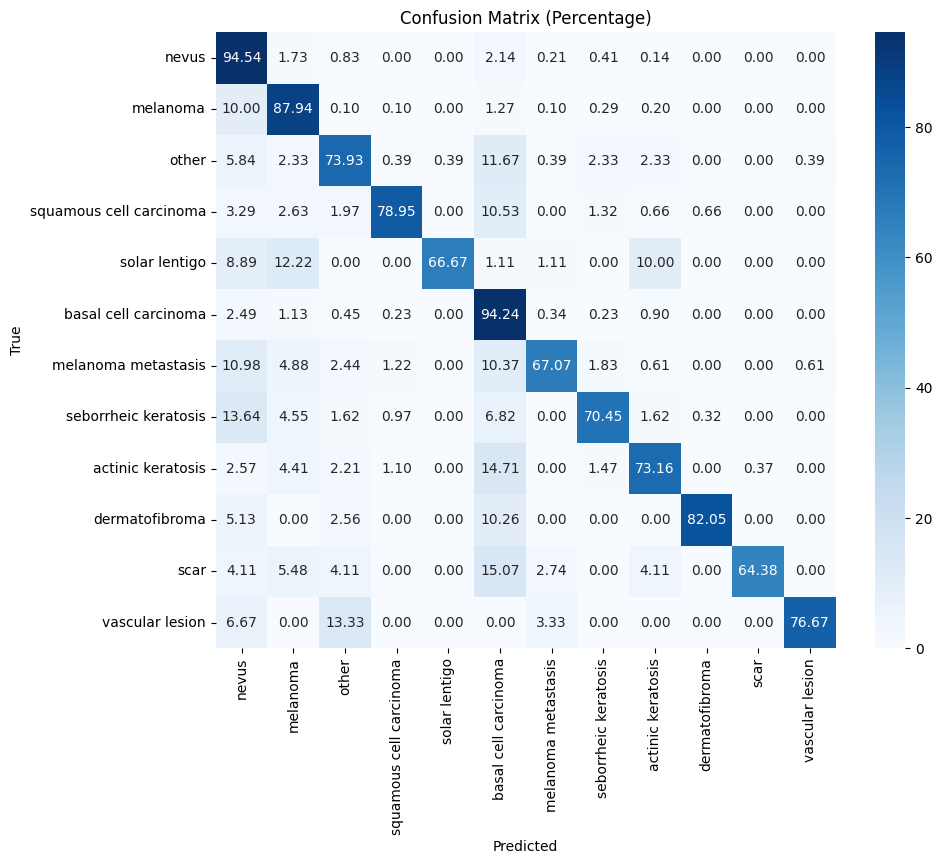

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

conf_matrix = confusion_matrix(y_true_all, y_pred_avg)
conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1, keepdims=True)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_percent * 100, annot=True, fmt=".2f", cmap='Blues',
            xticklabels=diagnosis_mapping.keys(), yticklabels=diagnosis_mapping.keys())

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Percentage)')
plt.show()
